In [22]:
import os
from os.path import expanduser
home_dir = expanduser("~")
module_path = home_dir + '/modules/'
import sys
sys.path.append(module_path)
import time
import importlib
import random
import tensorflow as tf
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
import model_management

np.random.seed(999)
random.seed(999)

In [59]:
### General parameters
run_on_cpu = False
nEpochs = 1e2
batchSize = 1e3
total_set_size = 100000 # how many examples will be used for training+validation+testing
train_size = 70000
val_size = 10000
test_size = 10000
early_stopping_param = 5
input_features = ['Halo_mass', 'Halo_mass_peak', 'Concentration', 'Halo_spin']
output_features = ['Stellar_mass', 'SFR']
save_figs = 1
fig_dir = 'figures/'

### Network parameters
nLayers = 10
activationFunction = 'tanh'
neuronsPerLayer = 10
loss_function = 'mse' # 'mse', 'weighted_mse_1' 'mae'

data_dict = {'X_pos': 0, 'Y_pos': 1, 'Z_pos': 2, 'X_vel': 3, 'Y_vel': 4, 
             'Z_vel': 5, 'Halo_mass': 6, 'Stellar_mass': 7, 'SFR': 8, 
             'Intra_cluster_mass': 9, 'Halo_mass_peak': 10, 
             'Stellar_mass_obs': 11, 'SFR_obs': 12, 'Halo_radius': 13, 
             'Concentration': 14, 'Halo_spin': 15, 'Type': 16}
unit_dict = {'X_pos': '', 'Y_pos': '', 'Z_pos': '', 'X_vel': '', 'Y_vel': '', 
             'Z_vel': '', 'Halo_mass': 'log($M_{G}/M_{S}$)', 'Stellar_mass': 'log($M_{G}/M_{S}$)', 'SFR': '', 
             'Intra_cluster_mass': '', 'Halo_mass_peak': 'log($M_{G}/M_{S}$)', 
             'Stellar_mass_obs': '', 'SFR_obs': '', 'Halo_radius': '', 
             'Concentration': '', 'Halo_spin': '', 'Type': ''}

In [24]:
if run_on_cpu:
    os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [39]:
### Set name ending with parameters for figures to be saved
param_string = 'nLayers_%d_nNeurons_%d_actFun_%s_lossFunc_%s_nTrainSamples_%d_nEpochs_%d_batchSize_%d' % (
    nLayers, neuronsPerLayer, activationFunction, loss_function, train_size, nEpochs, batchSize)
print(param_string)

nLayers_10_nNeurons_10_actFun_tanh_lossFunc_mae_nTrainSamples_270000_nEpochs_1000_batchSize_1000


# Load and preprocess the data

In [50]:
galfile = pd.read_hdf('/scratch/data/galcats/P200/galaxies.Z01.h5')
galaxies = galfile.as_matrix()
gal_header = galfile.keys().tolist()

### Remove data points with halo mass below 10.5
print(np.shape(galaxies))
galaxies = galaxies[galaxies[:,6] > 10.5, :]
print(np.shape(galaxies))
print(galaxies[:10,6])

halo_min_mass = np.min(galaxies[:, 6])
halo_max_mass = np.max(galaxies[:, 6])

(634742, 17)
(305382, 17)
[11.06128  10.74806  10.517851 11.935673 11.820144 11.564987 10.759135
 10.828308 10.803138 10.55098 ]


In [51]:
n_data_points = galaxies.shape[0]
subset_indices = np.random.choice(n_data_points, total_set_size, replace=False)
train_indices = subset_indices[: int(train_size)]
val_indices = subset_indices[int(train_size) : int(train_size+val_size)]
test_indices = subset_indices[int(train_size+val_size) :]

x_train = np.zeros((len(train_indices), len(input_features)))
x_val = np.zeros((len(val_indices), len(input_features)))
x_test = np.zeros((len(test_indices), len(input_features)))
y_train = np.zeros((len(train_indices), len(output_features)))
y_val = np.zeros((len(val_indices), len(output_features)))
y_test = np.zeros((len(test_indices), len(output_features)))

for i in range(len(input_features)):
    x_train[:,i] = galaxies[train_indices, data_dict[input_features[i]]]
    x_val[:,i] = galaxies[val_indices, data_dict[input_features[i]]]
    x_test[:,i] = galaxies[test_indices, data_dict[input_features[i]]]
    
for i in range(len(output_features)):
    y_train[:,i] = galaxies[train_indices, data_dict[output_features[i]]]
    y_val[:,i] = galaxies[val_indices, data_dict[output_features[i]]]
    y_test[:,i] = galaxies[test_indices, data_dict[output_features[i]]]

In [28]:
### ZERO MEAN, UNIT STD

norm = 'zero_mean_unit_std_norm'

for i in range(np.size(x_train, 1)):
    x_data_means = np.mean(x_train, 0)
    x_data_stds = np.std(x_train, 0)

    x_train_norm = (x_train - x_data_means) / x_data_stds
    x_val_norm = (x_val - x_data_means) / x_data_stds
    x_test_norm = (x_test - x_data_means) / x_data_stds

for i in range(np.size(y_train, 1)):
    y_data_means = np.mean(y_train, 0)
    y_data_stds = np.std(y_train, 0)

    y_train_norm = (y_train - y_data_means) / y_data_stds
    y_val_norm = (y_val - y_data_means) / y_data_stds
    y_test_norm = (y_test - y_data_means) / y_data_stds

In [58]:
### BETWEEN ZERO AND ONE

norm = 'zero_to_one_norm'

for i in range(np.size(x_train, 1)):
    x_data_max = np.max(x_train, 0)
    x_data_min = np.min(x_train, 0)

    x_train_norm = (x_train - x_data_min) / (x_data_max - x_data_min)
    x_val_norm = (x_val - x_data_min) / (x_data_max - x_data_min)
    x_test_norm = (x_test - x_data_min) / (x_data_max - x_data_min)

for i in range(np.size(y_train, 1)):
    y_data_max = np.max(y_train, 0)
    y_data_min = np.min(y_train, 0)

    y_train_norm = (y_train - y_data_min) / (y_data_max - y_data_min)
    y_val_norm = (y_val - y_data_min) / (y_data_max - y_data_min)
    y_test_norm = (y_test - y_data_min) / (y_data_max - y_data_min)

In [55]:
print(np.mean(y_test_norm, 0))
print(np.std(y_test_norm, 0))
print(np.min(x_test_norm, 0))
print(np.max(x_test_norm, 0))

[0.29924175 0.00646753]
[0.22092262 0.01791453]
[ 4.57835121e-05  0.00000000e+00 -9.50144380e-07  1.19973055e-03]
[0.87806939 0.87806381 0.9889168  0.54696208]


In [54]:
### Get a feel for the data
for i in range(len(input_features)):
    print(input_features[i],': min: %.2e, max: %.2e.' % (np.min(x_train[:,i]), np.max(x_train[:,i])))
for i in range(len(output_features)):
    print(output_features[i],': min: %.2e, max: %.2e.' % (np.min(y_train[:,i]), np.max(y_train[:,i])))

Halo_mass : min: 1.05e+01, max: 1.49e+01.
Halo_mass_peak : min: 1.05e+01, max: 1.49e+01.
Concentration : min: 1.00e+00, max: 1.65e+03.
Halo_spin : min: 5.00e-04, max: 6.09e-01.
Stellar_mass : min: 7.00e+00, max: 1.20e+01.
SFR : min: 0.00e+00, max: 3.40e+01.


In [56]:
from keras import backend as K
def weighted_mse_1(y_true, y_pred):
    
    return K.mean(K.log(y_true+1.5) + K.square(y_pred - y_true), axis=-1)
loss_func_dict = {
    'mse': 'mse',
    'mae': 'mae',
    'weighted_mse_1': weighted_mse_1
}

<IPython.core.display.Javascript object>


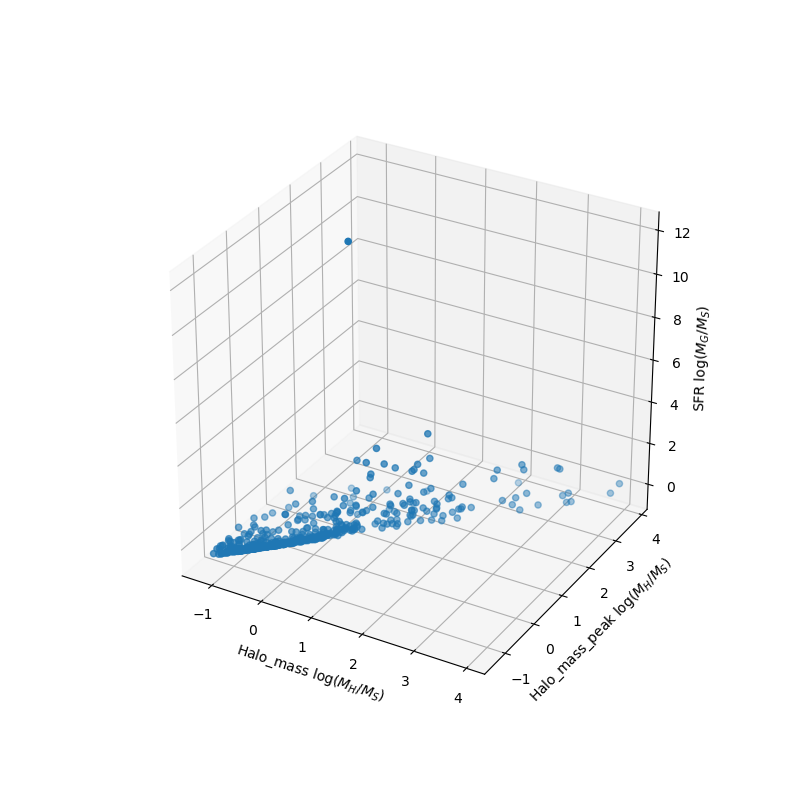

In [11]:
### Visualisation for when we have 2 input features
%matplotlib notebook
input_feat_1 = 0
input_feat_2 = 1
output_feat = 1

fig = plt.figure(1, figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_train_norm[:500,input_feat_1], x_train_norm[:500,input_feat_2], 
           y_train_norm[:500,output_feat])
ax.set_xlabel('%s log($M_{H}/M_{S}$)' % (input_features[input_feat_1]))
ax.set_ylabel('%s log($M_{H}/M_{S}$)' % (input_features[input_feat_2]))
ax.set_zlabel('%s log($M_{G}/M_{S}$)' % (output_features[output_feat]))
plt.show()

# Load an existing model

In [ ]:
### Search for the model that you want
importlib.reload(model_management)
search_dict = {
    'training_method': 'backprop'
}
[model_dicts, description_dicts] = model_management.SearchModel(search_dict, get_hits=True)
print(description_dicts)
print('\n')
for key in model_dicts:
    print(key)
    print(model_dicts[key])
    print('\n')


In [ ]:
importlib.reload(model_management)
model, model_dict, description = model_management.LoadModel(search_dict, 1)

# Create a new model

In [60]:
# create model
model = Sequential()
model.add(Dense(neuronsPerLayer, input_dim = len(input_features), activation = activationFunction))

for i in range(0, nLayers-1): # -1 because one layer is added automatically with the input layer
    model.add(Dense(neuronsPerLayer, activation = activationFunction))

model.add(Dense(len(output_features), activation = 'relu'))

# Compile model
model.compile(loss=loss_func_dict[loss_function], metrics=['mse'], optimizer='adam')#, metrics=[loss_function])

# Fit the model
early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_param)
history = model.fit(x_train_norm , y_train_norm, validation_data=(x_val_norm, y_val_norm), 
                    epochs=int(nEpochs), batch_size=int(batchSize))


Train on 70000 samples, validate on 10000 samples
Epoch 1/100
70000/70000 [==============================] - 1s 21us/step - loss: 0.0112 - mean_squared_error: 0.0112 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 2/100
70000/70000 [==============================] - 1s 12us/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 3/100
70000/70000 [==============================] - 1s 12us/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 4/100
70000/70000 [==============================] - 1s 12us/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 5/100
70000/70000 [==============================] - 1s 12us/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 6/100
70000/70000 [==============================] - 1s 12us/step - loss: 0.0014 - mean_squared_error: 0

70000/70000 [==============================] - 1s 12us/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 50/100
70000/70000 [==============================] - 1s 12us/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 51/100
70000/70000 [==============================] - 1s 12us/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 52/100
70000/70000 [==============================] - 1s 11us/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 53/100
70000/70000 [==============================] - 1s 12us/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 54/100
70000/70000 [==============================] - 1s 12us/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0012 - val_mean_squared_error: 0.0012

70000/70000 [==============================] - 1s 12us/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 98/100
70000/70000 [==============================] - 1s 12us/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 99/100
70000/70000 [==============================] - 1s 12us/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 100/100
70000/70000 [==============================] - 1s 12us/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0012 - val_mean_squared_error: 0.0012


# Plot loss history

In [32]:
# list all data in history
print(history.history.keys())

dict_keys(['val_loss', 'val_mean_squared_error', 'loss', 'mean_squared_error'])


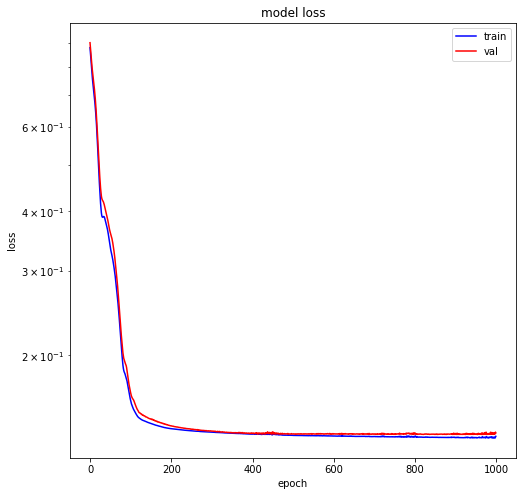

In [33]:
# summarize history for loss
%matplotlib inline
fig = plt.figure(5, figsize=(8,8))
plt.plot(history.history['loss'], 'b')
plt.plot(history.history['val_loss'], 'r')
plt.yscale('log')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

# Evaluate the model

In [34]:
# On preprocessed data
test_loss, test_mse = model.evaluate(x_test_norm, y_test_norm, verbose=0)
print('MSE for the processed data: %.4f' % (test_mse))

MSE for the processed data: 0.4497


In [63]:
### Predict real value of points
if norm == 'zero_mean_unit_std_norm':
    predicted_norm_points = model.predict(x_test_norm)
    predicted_points = predicted_norm_points * y_data_stds + y_data_means
    
if norm == 'zero_to_one_norm':
    predicted_norm_points = model.predict(x_test_norm)
    predicted_points = predicted_norm_points * (y_data_max - y_data_min) + y_data_min


In [65]:
### Get mse for the real predictions
n_points = np.shape(predicted_points)[0]
x_minus_y = predicted_points - y_test

feature_scores = np.sum(np.power(x_minus_y, 2), 0) / n_points
total_score = np.sum(feature_scores) / 2

print('MSE for the unprocessed data: %.4f' % (total_score))

MSE for the unprocessed data: 0.2346


# Save a model

In [ ]:
### Save the model if it is useful
importlib.reload(model_management)
model_dictionary = {
    'training_method': 'backprop',
    'input_features': input_features,
    'output_features': output_features,
    'number_of_epochs': nEpochs,
    'batch_size': batchSize,
    'number_of_layers': nLayers,
    'neurons_per_layer': neuronsPerLayer,
    'activation_function': activationFunction,
    'train_set_size': train_size,
    'loss_function': loss_function,
    'test_loss': test_loss,
    'test_mse': test_mse,
    'preprocess_data': preprocess_data
}
description = 'First network trained on preprocessed data.'
model_management.SaveModel(model, model_dictionary, description)

In [ ]:
%matplotlib notebook
#x1 = np.linspace(np.min(x_test[:,0]), np.max(x_test[:,0]), 30)
#x2 = np.linspace(np.min(x_test[:,1]), np.max(x_test[:,1]), 30)
#X1, X2 = np.meshgrid(x1, x2)
#Z = np.zeros(X1.shape)
#for i in range(30):
#    for j in range(30):
#        Z[i, j] = model.predict(np.array([X1[i,j], X2[i,j]])) TODO varför funkar inte det här??
        
#fig = plt.figure(4)
#ax = plt.axes(projection='3d')
#ax.contour3D(X, Y, Z, 50, cmap='binary')
#ax.set_xlabel('x')
#ax.set_ylabel('y')
#ax.set_zlabel('z')
        
### Old visualisation way
### Visualisation of prediction strength for when we have 2 input features
if plot_threeD and len(input_features) == 2:
    predictedY = model.predict(x_test_norm)
    predictedY = predictedY * y_data_stds + y_data_means
    fig = plt.figure(2, figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x_test[:,0], x_test[:,1], 
               y_test[:,0], s=3)
    ax.scatter(x_test[:,0], x_test[:,1], 
               predictedY, s=3)
    ax.set_xlabel('%s log($M_{H}/M_{S}$)' % (input_features[0]))
    ax.set_ylabel('%s log($M_{H}/M_{S}$)' % (input_features[1]))
    ax.set_zlabel('%s log($M_{G}/M_{S}$)' % (output_features[0]))

# Scatterplots and boxplots

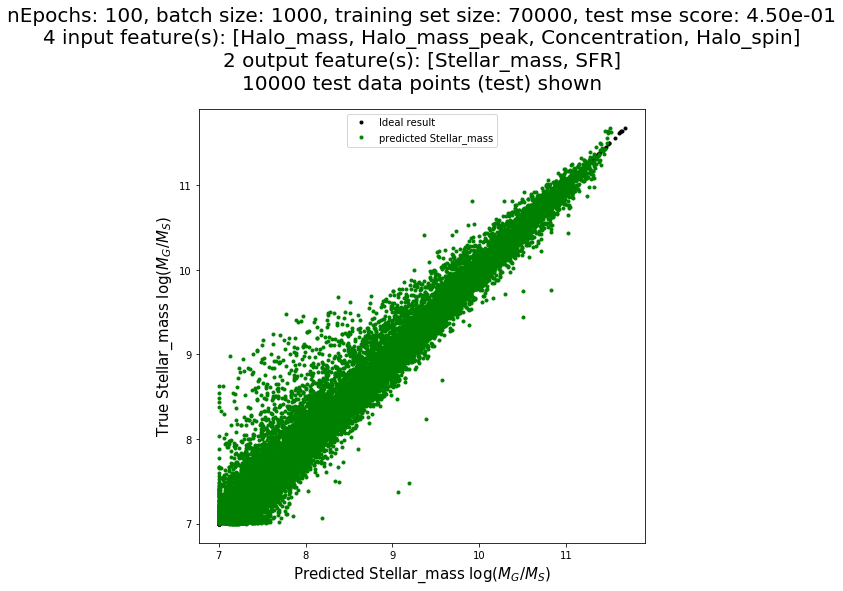

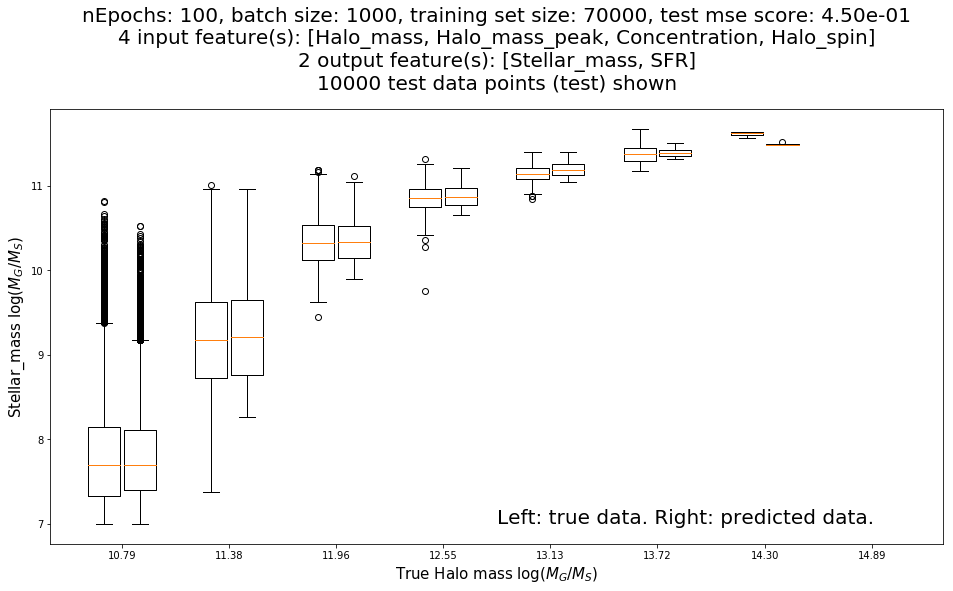

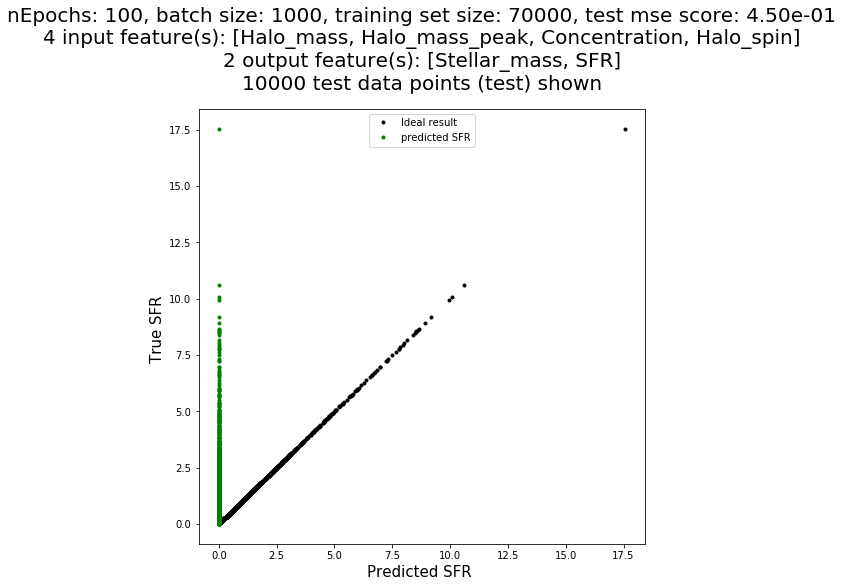

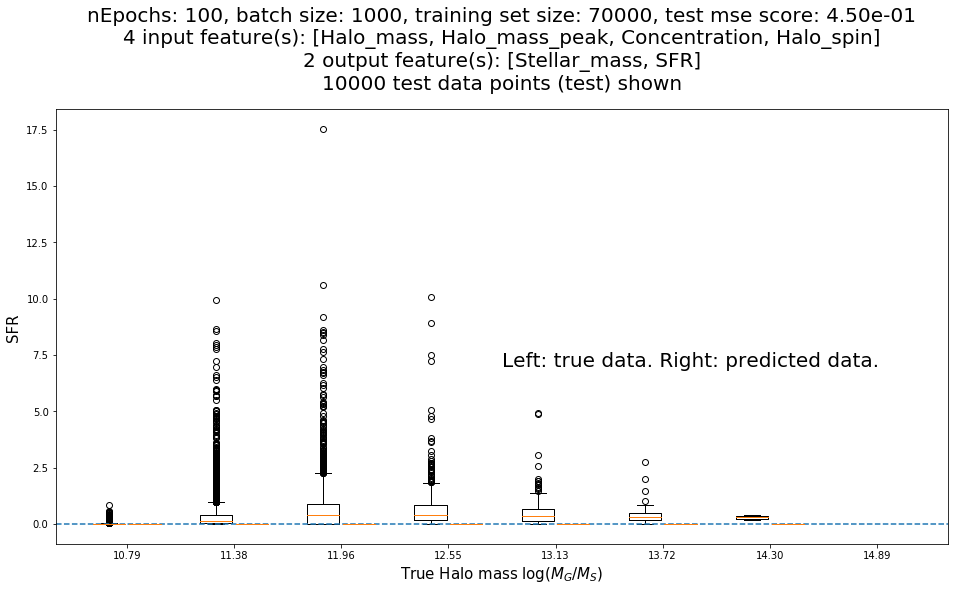

In [66]:
%matplotlib inline
#from pylab import plot, show, savefig, xlim, figure, \
#                hold, ylim, legend, boxplot, setp, axes
nBins = 8
bin_edges = np.linspace(halo_min_mass, halo_max_mass, nBins+1)

predictedY = predicted_points

for i, feat in enumerate(output_features):
    
    
    ### Plot 1
    fig = plt.figure(figsize=(8,8))
    
    plt.plot(y_test[:,i], y_test[:,i], 'k.')
    plt.plot(predictedY[:,i], y_test[:,i], 'g.')
    plt.ylabel('True %s %s' % (feat, unit_dict[feat]), fontsize=15)
    plt.xlabel('Predicted %s %s' % (feat, unit_dict[feat]), fontsize=15)
    plt.legend(['Ideal result', 'predicted ' + feat], loc='upper center')
    plt.title('nEpochs: %d, batch size: %d, training set size: %d, test mse score: %.2e\n' % (nEpochs, 
        batchSize, train_size, test_mse) + 
        '%d input feature(s): [%s]\n%d output feature(s): [%s]\n%d test data points (test) shown' % (
        len(input_features), ', '.join(input_features), len(output_features), ', '.join(output_features),
        test_size), y=1.03, fontsize=20)
    plt.show
        
    if save_figs:
        fig.savefig(fig_dir+'bp_output_scatter_%d_plot_from_' % (i+1)+'_and_'.join(input_features)+'_to_'+
            '_and_'.join(output_features)+'_with_'+param_string+'.png', bbox_inches = 'tight')
    
    ### Plot 2 - boxplot
    
    # bin_means contain (0: mean of the binned values, 1: bin edges, 2: numbers pointing each example to a bin)
    bin_means_true = stats.binned_statistic(x_test[:,i], y_test[:,i], bins=bin_edges)
    bin_means_pred = stats.binned_statistic(x_test[:,i], predictedY[:,i].flatten(), bins=bin_edges)
    bin_centers = []
    for iBin in range(nBins):
        bin_center = (bin_means_true[1][iBin] + bin_means_true[1][iBin+1]) / 2
        bin_centers.append('%.2f' % (bin_center))
    sorted_true_y_data = []
    sorted_pred_y_data = []
    for iBin in range(1,nBins+1):
        sorted_true_y_data.append(y_test[bin_means_true[2] == iBin, i])
        sorted_pred_y_data.append(predictedY[bin_means_pred[2] == iBin,i])
        
    fig = plt.figure(figsize=(16,8))
    ax = plt.subplot(111)

    bin_pos = np.array([-2,-1]) # (because this makes it work)
    x_label_centers = []
    for iBin in range(nBins):
        # Every boxplot adds 2 boxes, one from the true data and one from the predicted data
        bin_pos += 3 
        plt.boxplot([sorted_true_y_data[iBin], sorted_pred_y_data[iBin]] , positions = bin_pos, widths = 0.9)
        x_label_centers.append(np.mean(bin_pos))
    
    plt.ylabel('%s %s' % (feat, unit_dict[feat]), fontsize=15)
    plt.xlabel('True Halo mass log($M_{G}/M_{S}$)', fontsize=15)
    ax.set_xlim(left=x_label_centers[0]-2, right=x_label_centers[-1]+2)
    #xlim(0,bin_pos[1] + 1)
    plt.xticks(x_label_centers, bin_centers)
    plt.text(12,7,'Left: true data. Right: predicted data.', fontsize=20)
    
    if feat == 'SFR':
        ax.axhline(y=0, linestyle='--')
    
    plt.title('nEpochs: %d, batch size: %d, training set size: %d, test mse score: %.2e\n' % (nEpochs, 
        batchSize, train_size, test_mse) + 
        '%d input feature(s): [%s]\n%d output feature(s): [%s]\n%d test data points (test) shown' % (
        len(input_features), ', '.join(input_features), len(output_features), ', '.join(output_features),
        test_size), y=1.03, fontsize=20)
    
    plt.show()
    
    if save_figs:
        fig.savefig(fig_dir+'bp_output_boxplot_%d_from_' % (i+1)+'_and_'.join(input_features)+'_to_'+
            '_and_'.join(output_features)+'_with_'+param_string+'.png', bbox_inches = 'tight')

# Scatterplots and plots with errorbars

/opt/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/opt/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/opt/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


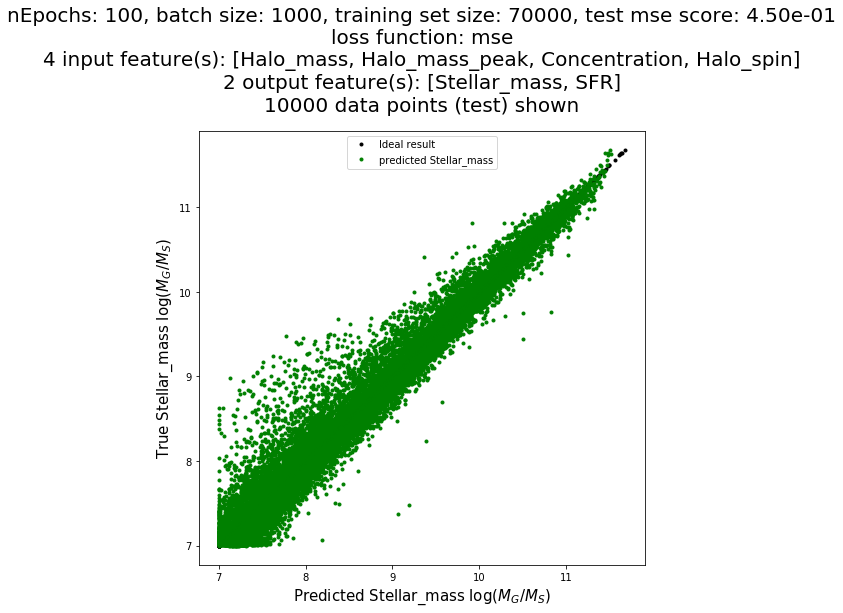

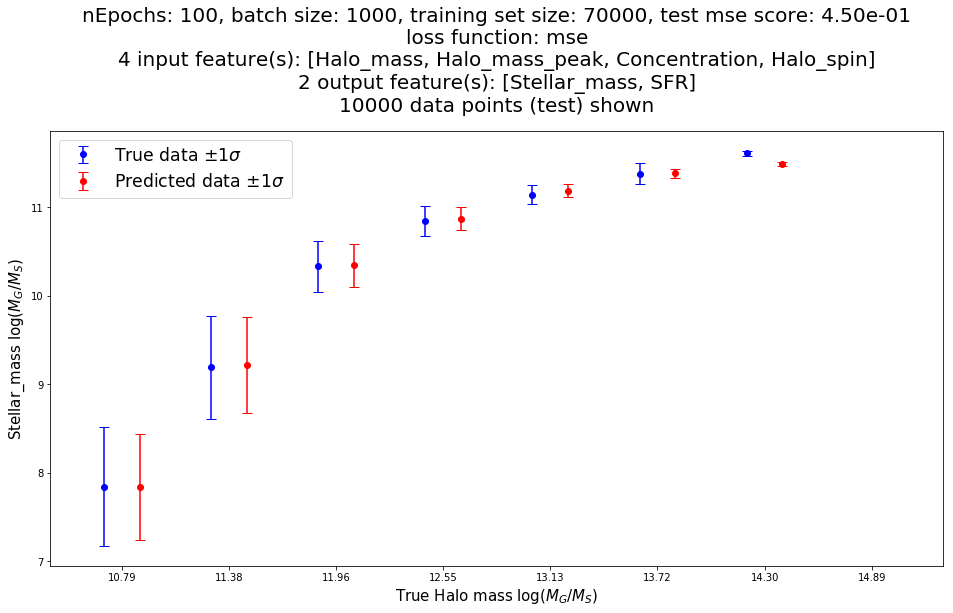

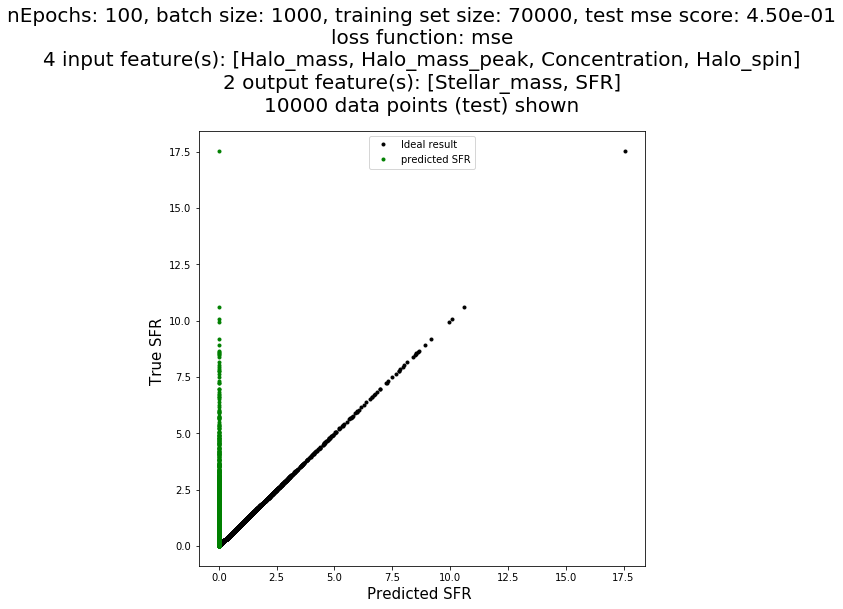

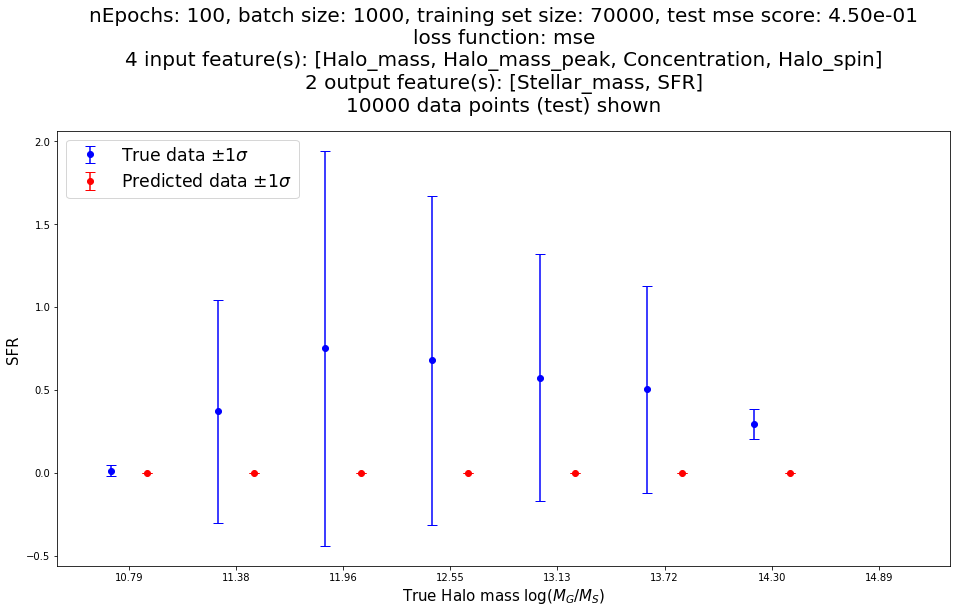

In [67]:
%matplotlib inline
#from pylab import plot, show, savefig, xlim, figure, \
#                hold, ylim, legend, boxplot, setp, axes
nBins = 8
bin_edges = np.linspace(halo_min_mass, halo_max_mass, nBins+1)

predictedY = predicted_points

for i, feat in enumerate(output_features):
    
    
    ### Plot 1
    fig = plt.figure(figsize=(8,8))
    
    plt.plot(y_test[:,i], y_test[:,i], 'k.')
    plt.plot(predictedY[:,i], y_test[:,i], 'g.')
    plt.ylabel('True %s %s' % (feat, unit_dict[feat]), fontsize=15)
    plt.xlabel('Predicted %s %s' % (feat, unit_dict[feat]), fontsize=15)
    plt.legend(['Ideal result', 'predicted ' + feat], loc='upper center')
    plt.title('nEpochs: %d, batch size: %d, training set size: %d, test mse score: %.2e\n' % (nEpochs, 
        batchSize, train_size, test_mse) + 'loss function: %s\n' % (loss_function) +
        '%d input feature(s): [%s]\n%d output feature(s): [%s]\n%d data points (test) shown' % (
        len(input_features), ', '.join(input_features), len(output_features), ', '.join(output_features),
        test_size), y=1.03, fontsize=20)
    plt.show
        
    if save_figs:
        fig.savefig(fig_dir+'bp_output_scatter_%d_plot_from_' % (i+1)+'_and_'.join(input_features)+'_to_'+
            '_and_'.join(output_features)+'_with_'+param_string+'.png', bbox_inches = 'tight')
    
    ### Plot 2 - boxplot
    
    # bin_means contain (0: mean of the binned values, 1: bin edges, 2: numbers pointing each example to a bin)
    bin_means_true = stats.binned_statistic(x_test[:,i], y_test[:,i], bins=bin_edges)
    bin_means_pred = stats.binned_statistic(x_test[:,i], predictedY[:,i].flatten(), bins=bin_edges)
    bin_centers = []
    for iBin in range(nBins):
        bin_center = (bin_means_true[1][iBin] + bin_means_true[1][iBin+1]) / 2
        bin_centers.append('%.2f' % (bin_center))
    sorted_true_y_data = []
    sorted_pred_y_data = []
    for iBin in range(1,nBins+1):
        sorted_true_y_data.append(y_test[bin_means_true[2] == iBin, i])
        sorted_pred_y_data.append(predictedY[bin_means_pred[2] == iBin,i])
    
    # get standard deviations of the binned values
    stds_true = np.zeros((nBins))
    stds_pred = np.zeros((nBins))
    for iBin in range(nBins):
        stds_true[iBin] = np.std(sorted_true_y_data[iBin])
        stds_pred[iBin] = np.std(sorted_pred_y_data[iBin])
        
    fig = plt.figure(figsize=(16,8))
    ax = plt.subplot(111)

    bin_pos = np.array([-2,-1]) # (because this makes it work)
    x_label_centers = []
    for iBin in range(nBins):
        # Every plot adds 2 distributions, one from the true data and one from the predicted data
        bin_pos += 3 
        plt.errorbar(bin_pos[0], bin_means_true[0][iBin], yerr=stds_true[iBin], fmt = 'bo', capsize=5)
        plt.errorbar(bin_pos[1], bin_means_pred[0][iBin], yerr=stds_pred[iBin], fmt = 'ro', capsize=5)
        x_label_centers.append(np.mean(bin_pos))
    
    plt.ylabel('%s %s' % (feat, unit_dict[feat]), fontsize=15)
    plt.xlabel('True Halo mass log($M_{G}/M_{S}$)', fontsize=15)
    plt.legend(['True data $\pm 1 \sigma$', 'Predicted data $\pm 1 \sigma$'], loc='upper left', fontsize='xx-large')
    ax.set_xlim(left=x_label_centers[0]-2, right=x_label_centers[-1]+2)
    #xlim(0,bin_pos[1] + 1)
    plt.xticks(x_label_centers, bin_centers)
    
    plt.title('nEpochs: %d, batch size: %d, training set size: %d, test mse score: %.2e\n' % (nEpochs, 
        batchSize, train_size, test_mse) + 'loss function: %s\n' % (loss_function) +
        '%d input feature(s): [%s]\n%d output feature(s): [%s]\n%d data points (test) shown' % (
        len(input_features), ', '.join(input_features), len(output_features), ', '.join(output_features),
        test_size), y=1.03, fontsize=20)
    
    plt.show()
    
    if save_figs:
        fig.savefig(fig_dir+'bp_output_boxplot_%d_from_' % (i+1)+'_and_'.join(input_features)+'_to_'+
            '_and_'.join(output_features)+'_with_'+param_string+'.png', bbox_inches = 'tight')

In [ ]:
#print(predictedY.flatten())
#bin_means = stats.binned_statistic(predictedY.flatten(), y_test[:,0], bins=10)
#bin_stds = stats.binned_statistic(predictedY.flatten(), y_test[:,0], bins=10, statistic=GetSTD)
#print(bin_means[0])
#print(bin_stds[0])

# Plot SFR vs Stellar mass

<function matplotlib.pyplot.show>

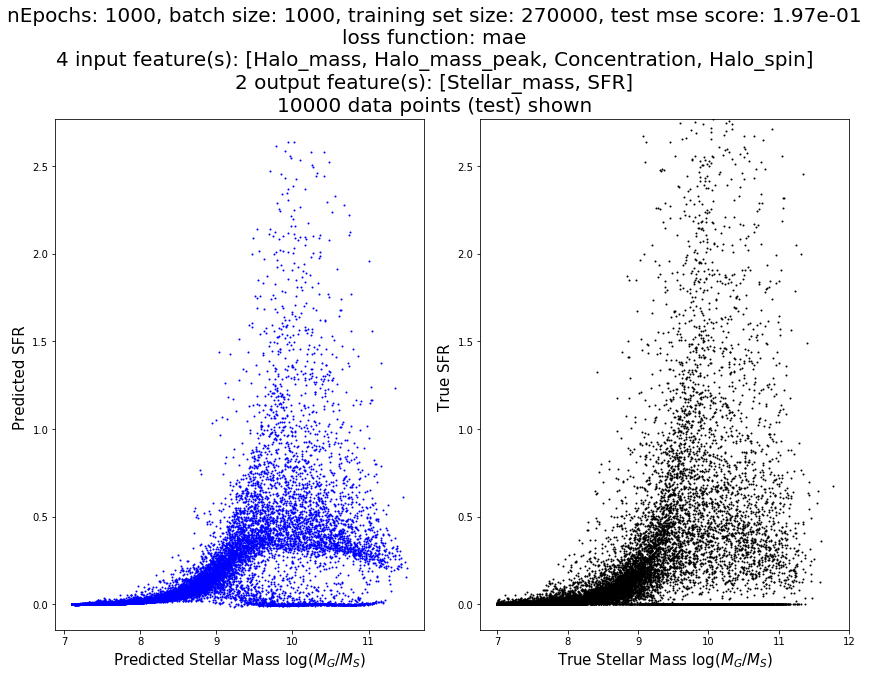

In [45]:
predictedY = model.predict(x_test_norm)
predictedY = predictedY * y_data_stds + y_data_means

fig = plt.figure(figsize=(12,8))
ax = plt.subplot(121)

plt.plot(predictedY[:,0], predictedY[:,1], 'b.', markersize=2)
plt.ylabel('Predicted SFR %s' % (unit_dict['SFR']), fontsize=15)
plt.xlabel('Predicted Stellar Mass %s' % (unit_dict['Stellar_mass']), fontsize=15)
ymin, ymax = ax.get_ylim()
ax.set_ylim(bottom=ymin, top=ymax)

ax = plt.subplot(122)
plt.plot(y_test[:,0], y_test[:,1], 'k.', markersize=2)
plt.ylabel('True SFR %s' % (unit_dict['SFR']), fontsize=15)
plt.xlabel('True Stellar Mass %s' % (unit_dict['Stellar_mass']), fontsize=15)
ax.set_ylim(bottom=ymin, top=ymax)
plt.suptitle('nEpochs: %d, batch size: %d, training set size: %d, test mse score: %.2e\n' % (nEpochs, 
    batchSize, train_size, total_score) + 'loss function: %s\n' % (loss_function) +
    '%d input feature(s): [%s]\n%d output feature(s): [%s]\n%d data points (test) shown' % (
    len(input_features), ', '.join(input_features), len(output_features), ', '.join(output_features),
    test_size), y=1.17, fontsize=20)
plt.tight_layout()
plt.show

In [46]:
### Save the figure
fig.savefig(fig_dir+'bp_sfr_to_stellar_mass_inputs_' + '_and_'.join(input_features)+
            '_with_'+param_string+'.png', bbox_inches = 'tight')

# Plot loss history

In [ ]:
# list all data in history
print(history.history.keys())

In [ ]:
# summarize history for loss
%matplotlib inline
fig = plt.figure(5, figsize=(8,8))
plt.plot(history.history['loss'], 'b')
plt.plot(history.history['val_loss'], 'r')
plt.yscale('log')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

# Check to see how the MSE is calculated 

In [ ]:
predicted_points = model.predict(x_test)
print(np.shape(predicted_points))
n_points = np.shape(predicted_points)[0]
x_minus_y = predicted_points - y_test

feature_scores = np.sum(np.power(x_minus_y, 2), 0) / n_points
total_score = np.sum(feature_scores) / 2

print(total_score)

keras_scores = model.evaluate(x_test, y_test, verbose=0)
print(keras_scores)

In [ ]:
# summarize history for loss
%matplotlib inline
fig = plt.figure(5, figsize=(8,8))
plt.plot(history.history['loss'], 'b')
plt.plot(history.history['val_loss'], 'r')
plt.yscale('log')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

# Plot loss history

In [ ]:
# list all data in history
print(history.history.keys())

In [ ]:
# summarize history for loss
%matplotlib inline
fig = plt.figure(5, figsize=(8,8))
plt.plot(history.history['loss'], 'b')
plt.plot(history.history['val_loss'], 'r')
plt.yscale('log')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

# Plot loss history

In [ ]:
# list all data in history
print(history.history.keys())